In [292]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for number crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns

/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx


In [293]:
os.listdir('/kaggle/input/telco-customer-churn-ibm-dataset')

['Telco_customer_churn.xlsx']

In [294]:
data = pd.read_excel('/kaggle/input/telco-customer-churn-ibm-dataset/Telco_customer_churn.xlsx')

data.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


# Dropping the columns that wont be used

In [295]:
data.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [296]:
data.drop(labels=['CustomerID','Count','Country','State','City','Zip Code','Lat Long','Latitude','Longitude','Churn Reason', 'Churn Label'], inplace=True, axis=1)

In [297]:
data.columns

Index(['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges', 'Churn Value',
       'Churn Score', 'CLTV'],
      dtype='object')

In [298]:
data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,86,3239
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,67,2701
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1,86,5372
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,...,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1,84,5003
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,...,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1,89,5340


# CLV Distribution

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


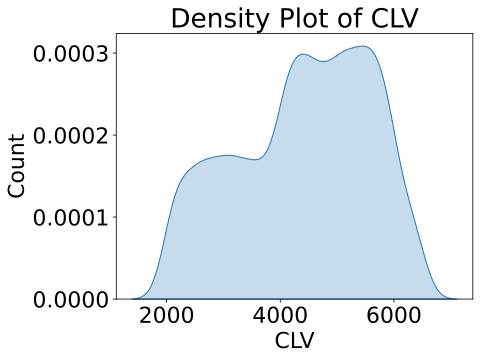

In [299]:
# Plotting CLV using a Kernell Density Estimation to see its distribution
sns.kdeplot(data['CLTV'], fill=True)

plt.xlabel("CLV")
plt.ylabel("Count")
plt.title("Density Plot of CLV")
plt.show()

# Data processing

In [300]:
# Replacing YES/NO booleans with 1/0
boolCols = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Paperless Billing']
data[boolCols] = data[boolCols].replace({"Yes":1, "No":0})

# Replacing classes with numerical values
classCols = ['Gender', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Payment Method']
le = LabelEncoder()

for col in classCols:
    data[col]= le.fit_transform(data[col])

data.head(5)

/tmp/ipykernel_47/180100237.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[boolCols] = data[boolCols].replace({"Yes":1, "No":0})


,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,1,0,0,0,2,1,0,0,2,2,...,0,0,0,1,3,53.85,108.15,1,86,3239
1,0,0,0,1,2,1,0,1,0,0,...,0,0,0,1,2,70.70,151.65,1,67,2701
2,0,0,0,1,8,1,2,1,0,0,...,2,2,0,1,2,99.65,820.5,1,86,5372
3,0,0,1,1,28,1,2,1,0,0,...,2,2,0,1,2,104.80,3046.05,1,84,5003
4,1,0,0,1,49,1,2,1,0,2,...,2,2,0,1,0,103.70,5036.3,1,89,5340


In [301]:
# z-score of numerical data! (Except Churn and CLV)
cols2zscore = ['Tenure Months', 'Monthly Charges', 'Total Charges']

#z-score
for col in cols2zscore:
    # Coerce turns "" and other invalid values into NaN
    data[col] = pd.to_numeric(data[col], errors='coerce') 
    
    # Drop rows when the column has a NaN
    data = data.dropna(subset=[col])
    
    meanval = np.mean(data[col])
    stdev = np.std(data[col], ddof=1)
    data[col] = (data[col]-meanval) / stdev

data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,...,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value,Churn Score,CLTV
0,1,0,0,0,-1.236636,1,0,0,2,2,...,0,0,0,1,3,-0.362635,-0.959581,1,86,3239
1,0,0,0,1,-1.236636,1,0,1,0,0,...,0,0,0,1,2,0.197351,-0.940391,1,67,2701
2,0,0,0,1,-0.992332,1,2,1,0,0,...,2,2,0,1,2,1.159463,-0.645323,1,86,5372
3,0,0,1,1,-0.177982,1,2,1,0,0,...,2,2,0,1,2,1.330616,0.336492,1,84,5003
4,1,0,0,1,0.677085,1,2,1,0,2,...,2,2,0,1,0,1.294059,1.214503,1,89,5340


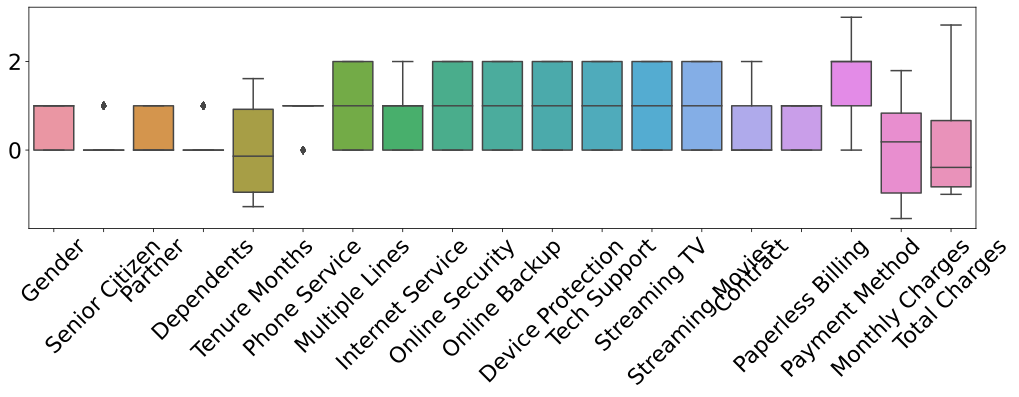

In [302]:
# check the new distribution
Showdata=data.drop(columns=['Churn Value', 'Churn Score', 'CLTV'])
fig,ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(Showdata)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.show()

In [303]:
# Eliminating Churn related columns (for now)
data.drop(labels=['Churn Value', 'Churn Score'], inplace=True, axis=1)

data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,CLTV
0,1,0,0,0,-1.236636,1,0,0,2,2,0,0,0,0,0,1,3,-0.362635,-0.959581,3239
1,0,0,0,1,-1.236636,1,0,1,0,0,0,0,0,0,0,1,2,0.197351,-0.940391,2701
2,0,0,0,1,-0.992332,1,2,1,0,0,2,0,2,2,0,1,2,1.159463,-0.645323,5372
3,0,0,1,1,-0.177982,1,2,1,0,0,2,2,2,2,0,1,2,1.330616,0.336492,5003
4,1,0,0,1,0.677085,1,2,1,0,2,2,0,2,2,0,1,0,1.294059,1.214503,5340


In [304]:
# Binarizing (boolean) the CLVT 
data['boolCLTV'] = 0
data.loc[data['CLTV']>5200, 'boolCLTV'] = 1

# Dropping unBinarized CLVT
data.drop(labels=['CLTV'], inplace=True, axis=1)

data.head(5)

,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,boolCLTV
0,1,0,0,0,-1.236636,1,0,0,2,2,0,0,0,0,0,1,3,-0.362635,-0.959581,0
1,0,0,0,1,-1.236636,1,0,1,0,0,0,0,0,0,0,1,2,0.197351,-0.940391,0
2,0,0,0,1,-0.992332,1,2,1,0,0,2,0,2,2,0,1,2,1.159463,-0.645323,1
3,0,0,1,1,-0.177982,1,2,1,0,0,2,2,2,2,0,1,2,1.330616,0.336492,0
4,1,0,0,1,0.677085,1,2,1,0,2,2,0,2,2,0,1,0,1.294059,1.214503,1


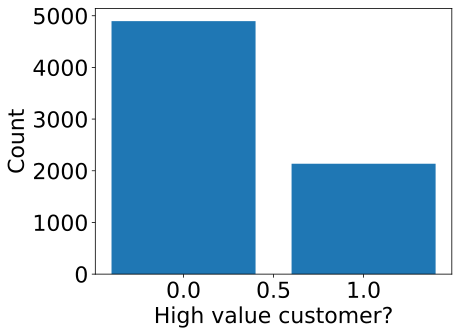

In [305]:
# distribution CLTV values
counts = data['boolCLTV'].value_counts()
plt.bar(list(counts.keys()),counts)
plt.xlabel('High value customer?')
plt.ylabel('Count')
plt.show()

# Re-organize the data: train/test in DataLoaders

In [306]:
# Pandas dataframe to tensor conversion
labels = torch.tensor( data['boolCLTV'].values ).float()
dataT  = torch.tensor( data.drop(labels=['boolCLTV'], axis=1).values ).float()
labels = labels[:,None] # transform to matrix

dataT.size()

torch.Size([7032, 19])

In [307]:
# using scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# Then converting them into PyTorch Datasets
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)


# train and test dataloaders
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset,batch_size=64, shuffle=True, drop_last=True)

In [308]:
# Creating a class for the model WITH BATCH NORM

class cltvnetWithBNorm(nn.Module):
  def __init__(self):
    super().__init__()

    # input layer
    self.input = nn.Linear(19,16)

    # hidden layers
    self.fc1    = nn.Linear(16,32)
    self.bnorm1 = nn.BatchNorm1d(16) # the number of units into this layer
    self.fc2    = nn.Linear(32,64)
    self.bnorm2 = nn.BatchNorm1d(32) # the number of units into this layer
    self.fc3    = nn.Linear(64,20)
    self.bnorm3 = nn.BatchNorm1d(64) # the number of units into this layer  

    # output layer
    self.output = nn.Linear(20,1)

  # forward pass
  def forward(self,x):

    # input (x starts off normalized)
    x = F.relu( self.input(x) )

    # hidden layer 1
    x = self.bnorm1(x) # batchnorm
    x = self.fc1(x)    # weighted combination
    x = F.relu(x)      # activation function
    
    # hidden layer 2
    x = self.bnorm2(x) # batchnorm
    x = self.fc2(x)    # weighted combination
    x = F.relu(x)      # activation function

    # hidden layer 3
    x = self.bnorm3(x) # batchnorm
    x = self.fc3(x)    # weighted combination
    x = F.relu(x)      # activation function


    # output layer
    return self.output(x)

In [309]:
# Function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(cltvnet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    cltvnet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = cltvnet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

    # Average training accuracy of the batch
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    # test accuracy
    cltvnet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = cltvnet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

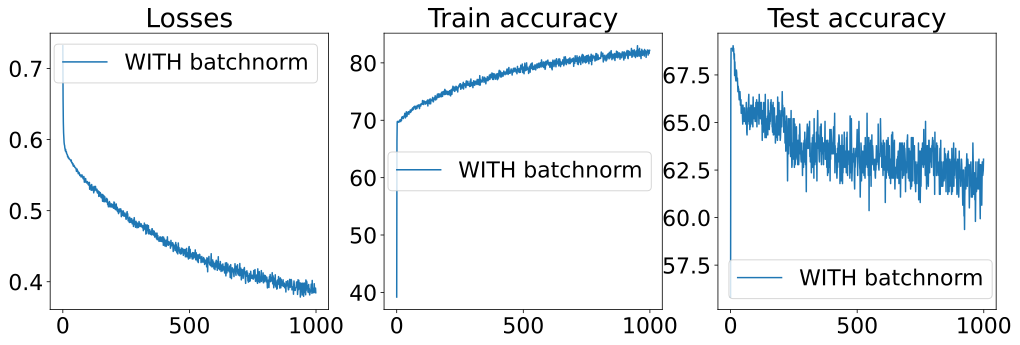

In [310]:
# create and train a model
cltvnet = cltvnetWithBNorm()
trainAcc,testAcc,losses = trainTheModel()

# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses,label='WITH batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAcc,label='WITH batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAcc,label='WITH batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()